In [90]:
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [99]:
# read data from file

df_r = pd.DataFrame()
df_t = pd.DataFrame()
df_e = pd.DataFrame()


file = open('fulldata_1567845665/all.txt', 'r') 

for line in file:
    values = line.split(', ')
    if values[0] == 'R':
        df_r = df_r.append({'timestamp': values[1],'r_speed': values[2],'r_pos': values[3].rstrip()}, ignore_index=True)    
    if values[0] == 'T':
        df_t = df_t.append({'timestamp': values[1],'t_pos': values[2].rstrip()}, ignore_index=True)   
    if values[0] == 'E':
        data_dict = json.loads(', '.join(values[2:]))
        data_dict['time'] = values[1]
        df_e = df_e.append(data_dict, ignore_index=True)   

file.close()

df_r['timestamp'] = pd.to_datetime(df_r['timestamp'],unit='s')
df_t['timestamp'] = pd.to_datetime(df_t['timestamp'],unit='s')
df_e['time'] = pd.to_datetime(df_e['time'],unit='s')
df_e = df_e.rename(columns={"time": "timestamp"})

df_r = df_r.set_index('timestamp')
df_t = df_t.set_index('timestamp')
df_e = df_e.set_index('timestamp')

df_e = df_e.drop(['forceplot'], axis=1)

df_r['r_speed'] = df_r['r_speed'].astype(float)
df_r['r_pos'] = df_r['r_pos'].astype(float)
df_t['t_pos'] = df_t['t_pos'].astype(float)

# df_e.head(20)

In [100]:
# merge all df

df = pd.concat([df_r, df_t, df_e], sort=False)
df = df.sort_index()
cols = ['calhr', 'calories', 'distance', 'heartrate', 'pace', 'power', 'spm', 'status', 'strokestate', 'r_pos', 'r_speed', 't_pos', 't_speed']
# df.loc[:,cols] = df.loc[:,cols].fillna(method='ffill')
# df

In [101]:
# resample data

resample_modes = {'calhr': 'mean',
                  'calories': 'mean',
                  'distance': 'mean',
                  'heartrate': 'mean',
                  'pace': 'mean',
                  'power': 'mean',
                  'spm': 'mean',
                  'r_pos': 'mean',
                  'r_speed': 'mean',
                  't_pos': 'mean',
                  'status': 'first',
                  'strokestate': 'first'}

df = df.resample('50ms').agg(resample_modes)
# df

In [102]:
# add synthetic data

# t_speed
df['t_speed'] = df['t_pos'] - df['t_pos'].shift(periods=1)

# t_speed_ut1
t_speed_last = df['t_speed'].shift(periods=1)
filter = (df['t_speed'] >= -100) & (t_speed_last < -100) & (df['t_pos'] <= 5000)    
df.loc[filter, 't_speed_ut1'] = 1

# t_speed_ut2
t_speed_last = df['t_speed'].shift(periods=1)
filter = (df['t_speed'] >= 100) & (t_speed_last < 100) & (df['t_pos'] <= 5000)    
df.loc[filter, 't_speed_ut2'] = 1

# df

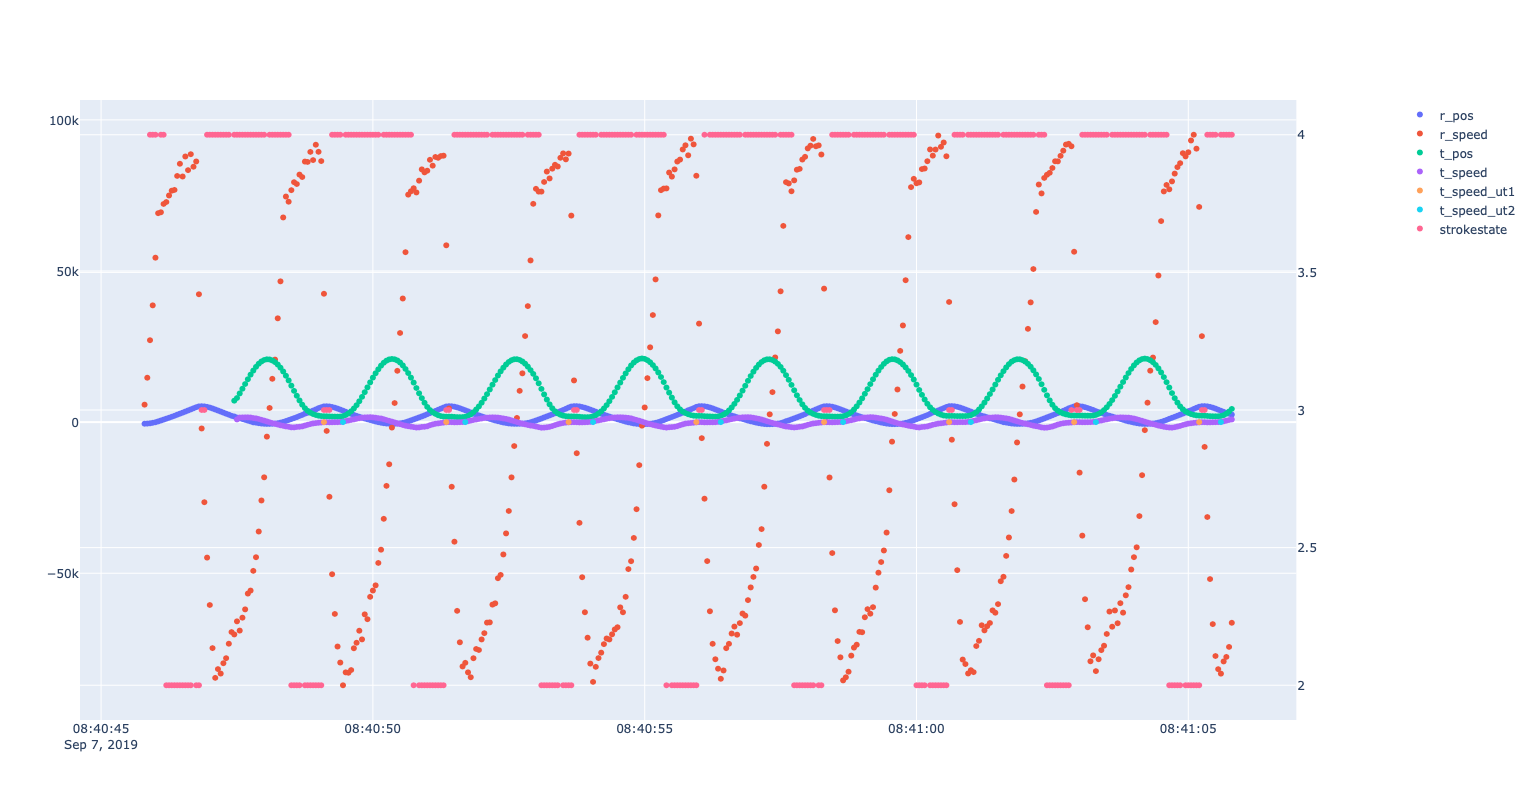

In [103]:
# plot data

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(
    autosize=False,
    width=1400,
    height=800
)

dfp = df[:4000]

# Add traces
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['r_pos'],
                    mode='markers',
                    name='r_pos'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['r_speed'],
                    mode='markers',
                    name='r_speed'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_pos'],
                    mode='markers',
                    name='t_pos'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_speed'],
                    mode='markers',
                    name='t_speed'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_speed_ut1'],
                    mode='markers',
                    name='t_speed_ut1'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_speed_ut2'],
                    mode='markers',
                    name='t_speed_ut2'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['strokestate'],
                    mode='markers',
                    name='strokestate'),
            secondary_y=True)

fig.show()